### Basic Analysis on the CAGE data

In [143]:
import pandas as pd
import pyBigWig
from matplotlib import pyplot as plt
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm
import os

In [144]:
DATA_PATH = "../data/ML4G_Project_1_Data"
CAGE_PATH = "CAGE-train/CAGE-train"
DNASE_PATH = "DNase-bed"

In [145]:
# Loading the data from the _info files
# there is X1, train and val (info and y)

dfs = {}
for i in range(3):
    for split in ["train", "val"] if i < 2 else ["test"]:
        info_path = os.path.join(DATA_PATH, CAGE_PATH, f"X{i+1}_{split}_info.tsv")
        df_info = pd.read_csv(info_path, sep="\t")
        dfs[f"X{i+1}_{split}_info"] = df_info

        if i == 2:
            continue
        y_path = os.path.join(DATA_PATH, CAGE_PATH, f"X{i+1}_{split}_y.tsv")
        df_y = pd.read_csv(y_path, sep="\t")
        dfs[f"X{i+1}_{split}_y"] = df_y

In [146]:
dfs["X1_train_info"].head()

,gene_name,chr,gene_start,gene_end,TSS_start,TSS_end,strand
0,SLC20A1,chr2,112645939,112663825,112658362,112658412,+
1,C11orf58,chr11,16613132,16758340,16738643,16738693,+
2,ZSCAN9,chr6,28224886,28233487,28225263,28225313,+
3,CD19,chr16,28931965,28939342,28931956,28932006,+
4,TMEM123,chr11,102396332,102470384,102452789,102452839,-


In [147]:
# assert that the lengths of the corresponding info and y files are the same
for i in range(2):
    for split in ["train", "val"]:
        assert len(dfs[f"X{i+1}_{split}_info"]) == len(dfs[f"X{i+1}_{split}_y"])

In [148]:
# Merge the info and y files, by adding the "gex" column from "y" to "info"
for i in range(2):
    for split in ["train", "val"]:
        df_info = dfs[f"X{i+1}_{split}_info"]
        df_y = dfs[f"X{i+1}_{split}_y"]
        df_info["gex"] = df_y["gex"]
        dfs[f"X{i+1}_{split}"] = df_info
        del dfs[f"X{i+1}_{split}_info"]
        del dfs[f"X{i+1}_{split}_y"]

In [149]:
dfs.keys()

dict_keys(['X3_test_info', 'X1_train', 'X1_val', 'X2_train', 'X2_val'])

In [150]:
# Generating gene length and TSS length in "info" dataframes
for key in dfs.keys():
    df = dfs[key]
    df["gene_length"] = df["gene_end"] - df["gene_start"]
    df["tss_length"] = df["TSS_end"] - df["TSS_start"]

In [151]:
# Display basic info and statistics
print("Data Summary:")
dfs["X1_train"].info()

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gene_name    14310 non-null  object 
 1   chr          14310 non-null  object 
 2   gene_start   14310 non-null  int64  
 3   gene_end     14310 non-null  int64  
 4   TSS_start    14310 non-null  int64  
 5   TSS_end      14310 non-null  int64  
 6   strand       14310 non-null  object 
 7   gex          14310 non-null  float64
 8   gene_length  14310 non-null  int64  
 9   tss_length   14310 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 1.1+ MB


In [152]:
dfs["X1_val"].describe()

,gene_start,gene_end,TSS_start,TSS_end,gex,gene_length,tss_length
count,1.974000e+03,1.974000e+03,1.974000e+03,1.974000e+03,1974.000000,1.974000e+03,1974.000000
mean,3.973398e+07,3.977206e+07,3.975193e+07,3.975198e+07,64.202102,3.808285e+04,48.673252
std,2.618095e+07,2.619457e+07,2.618647e+07,2.618647e+07,294.637287,7.816467e+04,5.448847
min,1.071040e+05,1.171020e+05,1.106120e+05,1.106620e+05,0.000000,4.920000e+02,2.000000
25%,1.753139e+07,1.756117e+07,1.754162e+07,1.754167e+07,0.000000,8.493500e+03,50.000000
50%,4.033400e+07,4.036448e+07,4.035436e+07,4.035440e+07,0.000000,1.761250e+04,50.000000
75%,5.447410e+07,5.448706e+07,5.449934e+07,5.449939e+07,13.454995,3.774875e+04,50.000000
max,1.055266e+08,1.055302e+08,1.055271e+08,1.055272e+08,4906.459916,1.697918e+06,50.000000


In [154]:
# Min, avg, max gene expression (gex) values over all "y" dataframes
for key in dfs.keys():
    if key == "X3_test_info":
        continue
    df = dfs[key]
    print(f"{key}: Min: {df['gex'].min()}, Avg: {df['gex'].mean()}, Max: {df['gex'].max()}")

X1_train: Min: 0.0, Avg: 50.09205731530775, Max: 19519.8335271173
X1_val: Min: 0.0, Avg: 64.20210206850176, Max: 4906.45991593704
X2_train: Min: 0.0, Avg: 51.73973263003801, Max: 19512.4842719895
X2_val: Min: 0.0, Avg: 61.473903323577275, Max: 4904.61262427614


In [155]:
print("\nSummary Statistics:")
dfs["X1_train"].describe()


Summary Statistics:


,gene_start,gene_end,TSS_start,TSS_end,gex,gene_length,tss_length
count,1.431000e+04,1.431000e+04,1.431000e+04,1.431000e+04,14310.000000,1.431000e+04,14310.000000
mean,7.268715e+07,7.276233e+07,7.272453e+07,7.272458e+07,50.092057,7.518262e+04,49.005800
std,5.236017e+07,5.236763e+07,5.236355e+07,5.236355e+07,322.331268,1.413789e+05,4.651564
min,1.447500e+04,4.687000e+04,2.968900e+04,2.973900e+04,0.000000,7.500000e+01,3.000000
25%,3.196178e+07,3.204239e+07,3.201700e+07,3.201704e+07,0.000000,1.063825e+04,50.000000
50%,6.187080e+07,6.204875e+07,6.195899e+07,6.195904e+07,0.000000,3.063850e+04,50.000000
75%,1.089405e+08,1.090945e+08,1.090191e+08,1.090192e+08,7.880783,8.058325e+04,50.000000
max,2.418940e+08,2.419026e+08,2.418991e+08,2.418991e+08,19519.833527,2.473538e+06,50.000000


In [156]:
# Print, avg, min and max gene and TSS length for all "info" dataframes
for key in dfs.keys():
    df = dfs[key]
    print(f"\n{key}:")
    print(f"Gene length: min={df['gene_length'].min()}, avg={df['gene_length'].mean()}, max={df['gene_length'].max()}")
    print(f"TSS length: min={df['tss_length'].min()}, avg={df['tss_length'].mean()}, max={df['tss_length'].max()}")


X3_test_info:
Gene length: min=269, avg=58244.293850806454, max=1551956
TSS length: min=11, avg=48.94254032258065, max=50

X1_train:
Gene length: min=75, avg=75182.61921733053, max=2473538
TSS length: min=3, avg=49.00580013976241, max=50

X1_val:
Gene length: min=492, avg=38082.84853090172, max=1697918
TSS length: min=2, avg=48.67325227963526, max=50

X2_train:
Gene length: min=75, avg=75182.61921733053, max=2473538
TSS length: min=3, avg=49.01488469601677, max=50

X2_val:
Gene length: min=492, avg=38082.84853090172, max=1697918
TSS length: min=3, avg=48.675278622087134, max=50


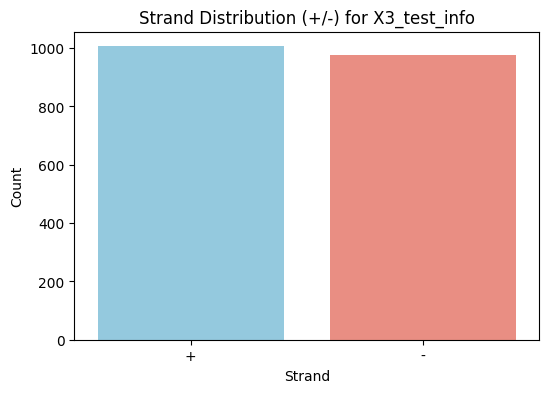

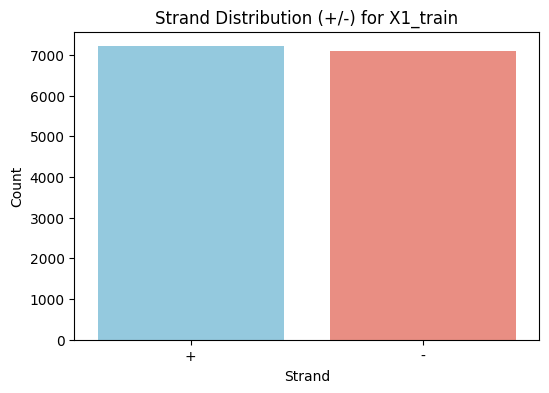

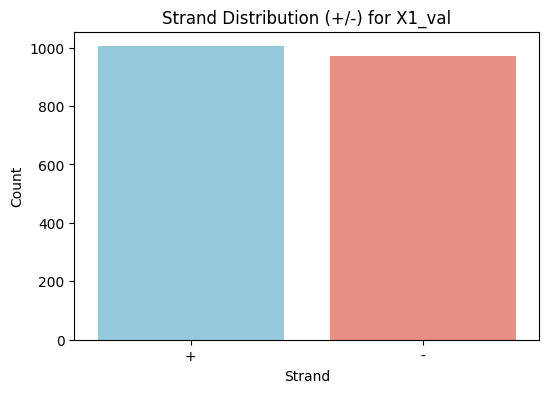

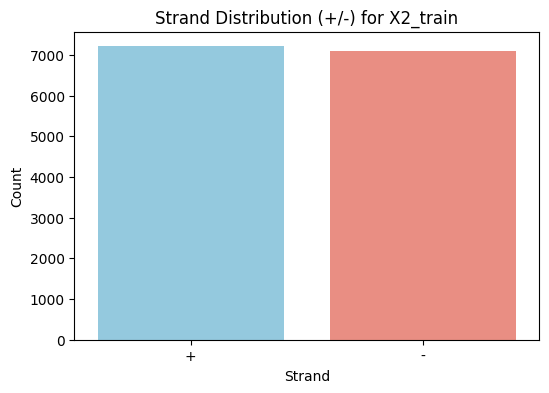

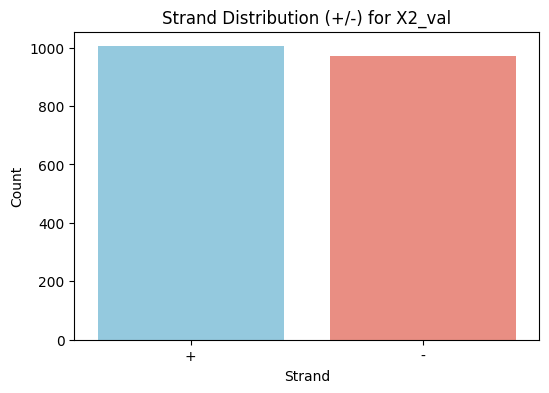

In [157]:
# Strand distribution
def plot_strand_distribution(df, title):
    # Define a color palette mapping + to one color and - to another
    strand_palette = {'+': 'skyblue', '-': 'salmon'}

    # Strand distribution with consistent order and colors
    plt.figure(figsize=(6, 4))
    sns.countplot(x='strand', data=df, hue='strand', palette=strand_palette, order=['+', '-'], legend=False)
    plt.title('Strand Distribution (+/-) for ' + title)
    plt.xlabel('Strand')
    plt.ylabel('Count')
    plt.show()


# Plot strand distribution for all "info" dataframes
for key in dfs.keys():
    plot_strand_distribution(dfs[key], key)

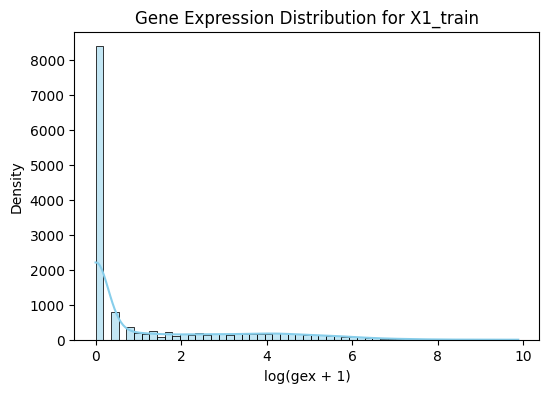

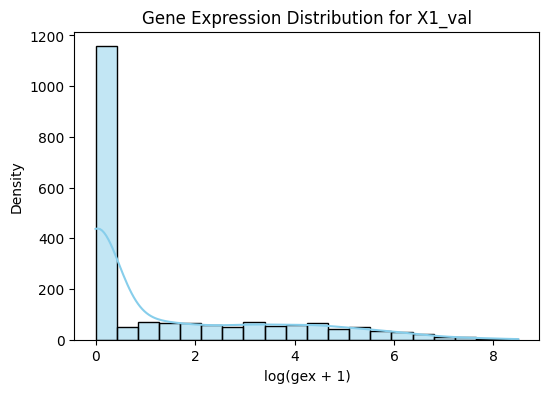

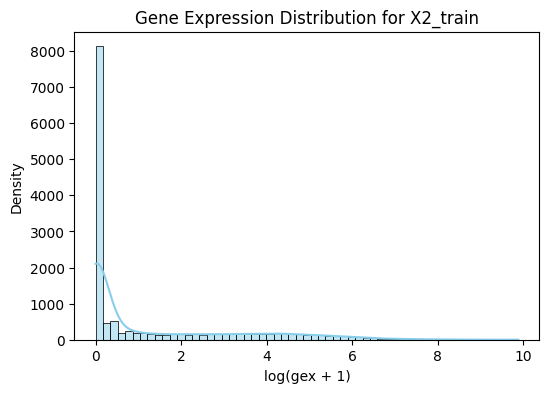

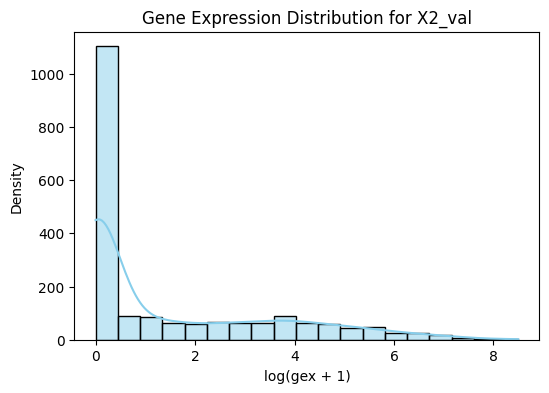

In [158]:
# Gene expression distribution
def plot_gene_expression_distribution(df, title):
    plt.figure(figsize=(6, 4))
    sns.histplot(df["log_gex"], kde=True, color='skyblue')
    plt.title('Gene Expression Distribution for ' + title)
    plt.xlabel('log(gex + 1)')
    plt.ylabel('Density')
    plt.show()


# Iterate over all "y" dataframes and plot gene expression distribution 
# Apply first a log-transformation to the gene expression values
for key in dfs.keys():
    if key == "X3_test_info":
        continue
    dfs[key]["log_gex"] = dfs[key]["gex"].apply(lambda x: math.log(x + 1)) 
    plot_gene_expression_distribution(dfs[key], key) 

In [159]:
# min, avg, max of log-transformed gene expression values
for key in dfs.keys():
    if key == "X3_test_info":
        continue
    df = dfs[key]
    print(f"{key} - Log-GEX: Min: {df['log_gex'].min()}, Avg: {df['log_gex'].mean()}, Max: {df['log_gex'].max()}")
    print(f"{key} - GEX: Min: {df['gex'].min()}, Avg: {df['gex'].mean()}, Max: {df['gex'].max()}")
    print()

X1_train - Log-GEX: Min: 0.0, Avg: 1.2256938195253264, Max: 9.879237560239702
X1_train - GEX: Min: 0.0, Avg: 50.09205731530775, Max: 19519.8335271173

X1_val - Log-GEX: Min: 0.0, Avg: 1.414001959556708, Max: 8.498511758198163
X1_val - GEX: Min: 0.0, Avg: 64.20210206850176, Max: 4906.45991593704

X2_train - Log-GEX: Min: 0.0, Avg: 1.2351556000674526, Max: 9.878861006702762
X2_train - GEX: Min: 0.0, Avg: 51.73973263003801, Max: 19512.4842719895

X2_val - Log-GEX: Min: 0.0, Avg: 1.465627519706274, Max: 8.498135262115992
X2_val - GEX: Min: 0.0, Avg: 61.473903323577275, Max: 4904.61262427614



In [160]:
# Count how many records have a gene expression value lower than 0
for key in dfs.keys():
    if key == "X3_test_info":
        continue
    df = dfs[key]
    print(f"{key}: {df[df['gex'] < 0].shape[0]} records have a gene expression value lower than 1")

X1_train: 0 records have a gene expression value lower than 1
X1_val: 0 records have a gene expression value lower than 1
X2_train: 0 records have a gene expression value lower than 1
X2_val: 0 records have a gene expression value lower than 1


### Histone Marks Data Analysis

In [176]:
HISTONE_MARKS = ["H3K4me1", "H3K4me3", "H3K9me3", "H3K27ac", "H3K36me3", "H3K27me3"]

region_map = {
    "H3K4me1": "enhancer",
    "H3K4me3": "promoter",
    "H3K9me3": "heterochromatin",
    "H3K27ac": "enhancer/promoter",
    "H3K36me3": "gene body",
    "H3K27me3": "promoter"
}

effect_map = {
    "H3K4me1": "poised/active enhancers",
    "H3K4me3": "active",
    "H3K27ac": "active",
    "H3K36me3": "transcriptional elongation",
    "H3K9me3": "repressive",
    "H3K27me3": "repressive"
}

# Activating Marks:

# H3K4me3: Active transcription (promoters).
# H3K27ac: Active transcription (enhancers/promoters).
# H3K4me1: Poised/active enhancers (enhancers, sometimes promoters).
# H3K36me3: Associated with transcriptional elongation (gene bodies).

# Repressive Marks:

# H3K9me3: Repressive mark associated with heterochromatin (gene silencing).
# H3K27me3: Repressive mark linked to Polycomb-mediated gene silencing (reversible gene silencing).

In [162]:
bigwig_dfs = {}
# we have under each DATA_PATH/HISTONE_MARK-bigwig folder X1, X2 and X2 .bw / .bigwig files
for mark in HISTONE_MARKS:
    bigwig_dfs[mark] = {}
    for i in range(3):
        bigwig_path = os.path.join(DATA_PATH, f"{mark}-bigwig", f"X{i+1}.bigwig")

        # check if it exists, otherwise its .bw
        if not os.path.exists(bigwig_path):
            bigwig_path = os.path.join(DATA_PATH, f"{mark}-bigwig", f"X{i+1}.bw")

        # Open bigwig file
        bw = pyBigWig.open(bigwig_path)
        bigwig_dfs[mark][f"X{i+1}"] = bw

In [163]:
bigwig_dfs["H3K4me1"]["X1"].header()

{'version': 4,
 'nLevels': 10,
 'nBasesCovered': 3095465794,
 'minVal': 0,
 'maxVal': 55,
 'sumData': 1125463741,
 'sumSquared': 2622444312}

In [164]:
def extract_bigwig_signal(df, bw, region_size=1000):
    signals = []
    with tqdm(total=len(df)) as pbar:
        for idx, row in df.iterrows():
            pbar.update(1)

            # Get signal around TSS (+/- region_size bp)
            start = max(0, row['TSS_start'] - region_size)
            end = row['TSS_end'] + region_size
            signal = bw.values(row['chr'], start, end)
            signals.append(sum(signal) / len(signal))  # Example: mean signal
    return signals

# Extract signal for all histone marks and all "info" dataframes
for mark in HISTONE_MARKS:
    for key in dfs.keys():
        print(f"Extracting signal for {mark} - {key}")
        df = dfs[key]
        bw = bigwig_dfs[mark][key.split("_")[0]]
        df[mark] = extract_bigwig_signal(df, bw)

100%|██████████| 1974/1974 [00:00<00:00, 2960.15it/s]


In [165]:
dfs["X1_train"].head()

,gene_name,chr,gene_start,gene_end,TSS_start,TSS_end,strand,gex,gene_length,tss_length,log_gex,H3K4me1,H3K4me3,H3K9me3,H3K27ac,H3K36me3,H3K27me3
0,SLC20A1,chr2,112645939,112663825,112658362,112658412,+,0.000000,17886,50,0.000000,2.253103,1.208303,0.363702,2.028687,1.959006,0.053125
1,C11orf58,chr11,16613132,16758340,16738643,16738693,+,2239.103328,145208,50,7.714277,0.636090,37.616613,0.496203,37.299372,0.252116,0.107353
2,ZSCAN9,chr6,28224886,28233487,28225263,28225313,+,19.798064,8601,50,3.034860,0.911592,23.953283,0.365062,7.506805,0.365821,0.514049
3,CD19,chr16,28931965,28939342,28931956,28932006,+,411.530623,7377,50,6.022310,4.027436,39.358784,0.348933,27.378167,0.148092,0.000673
4,TMEM123,chr11,102396332,102470384,102452789,102452839,-,34.214129,74052,50,3.561447,1.003249,23.805733,0.341313,12.740774,0.281544,0.438618


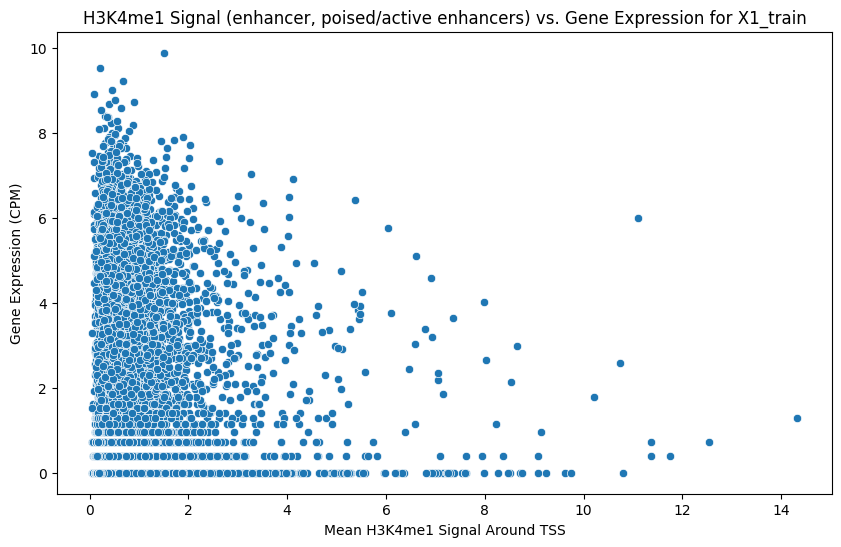

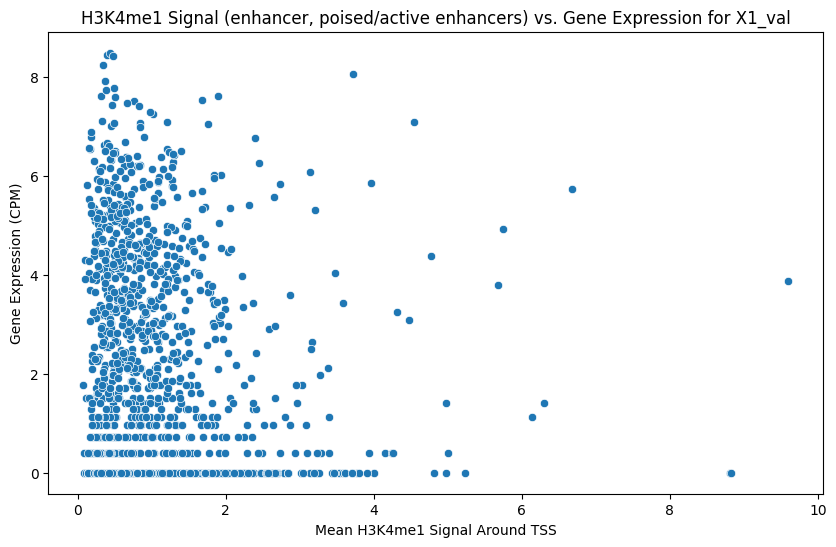

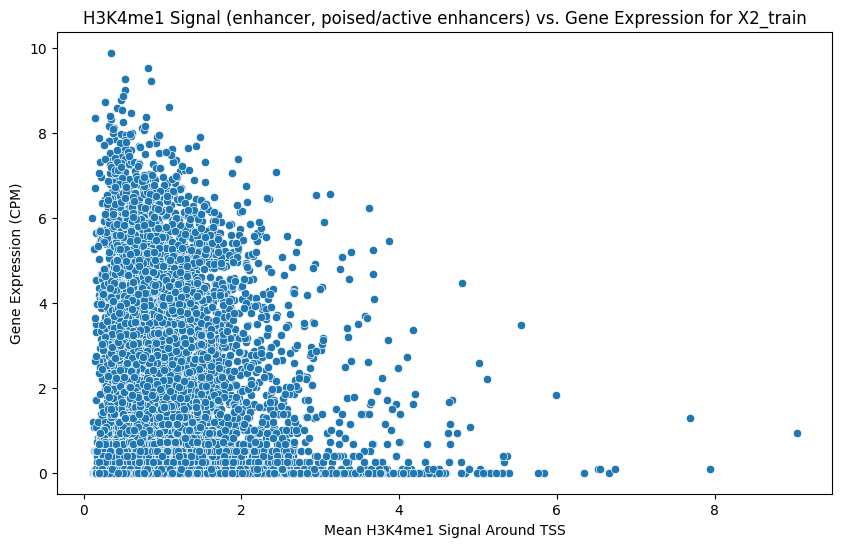

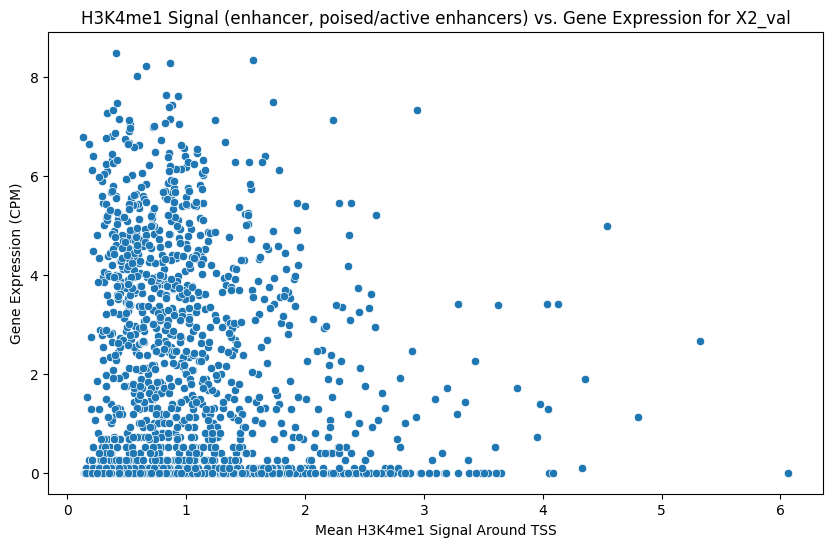

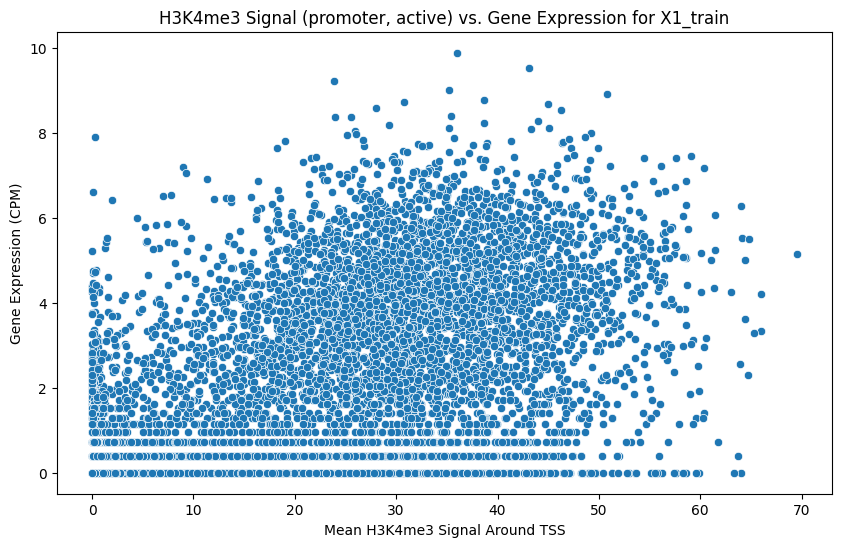

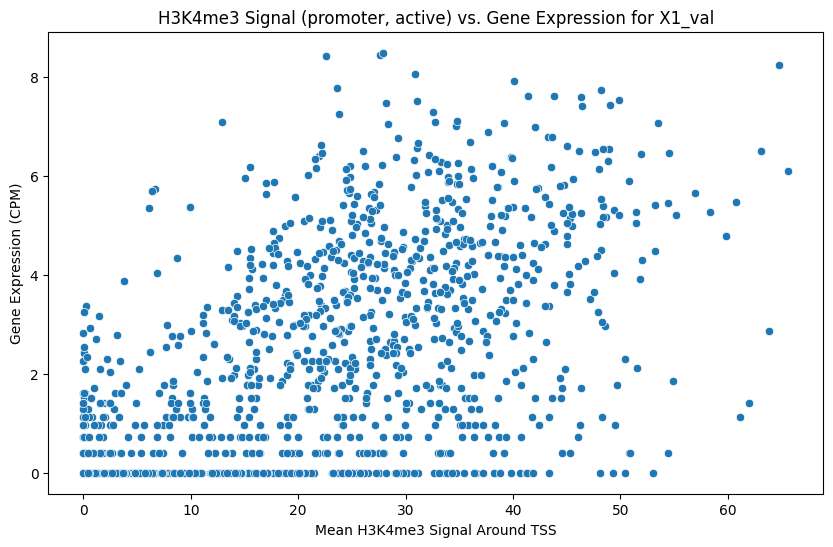

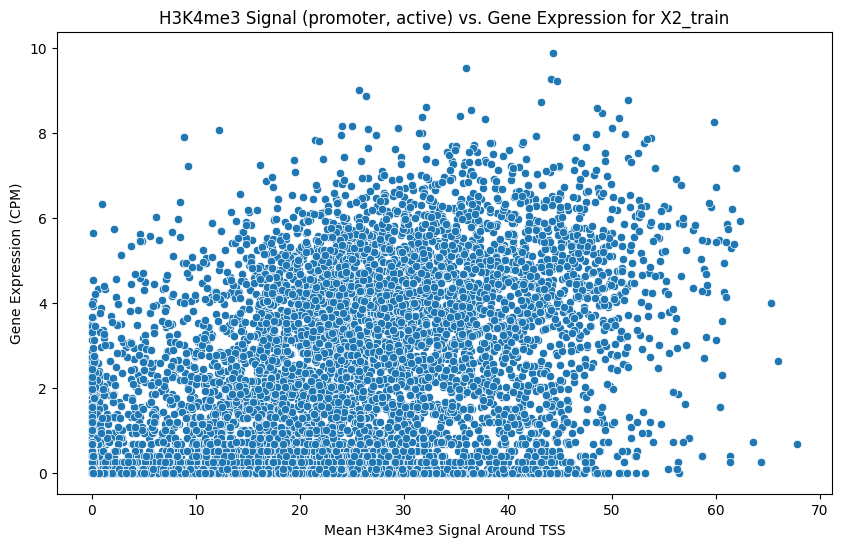

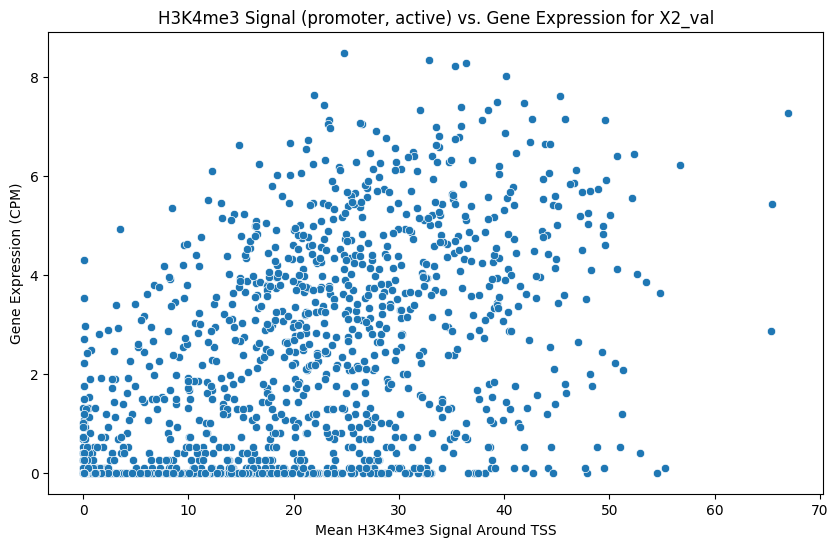

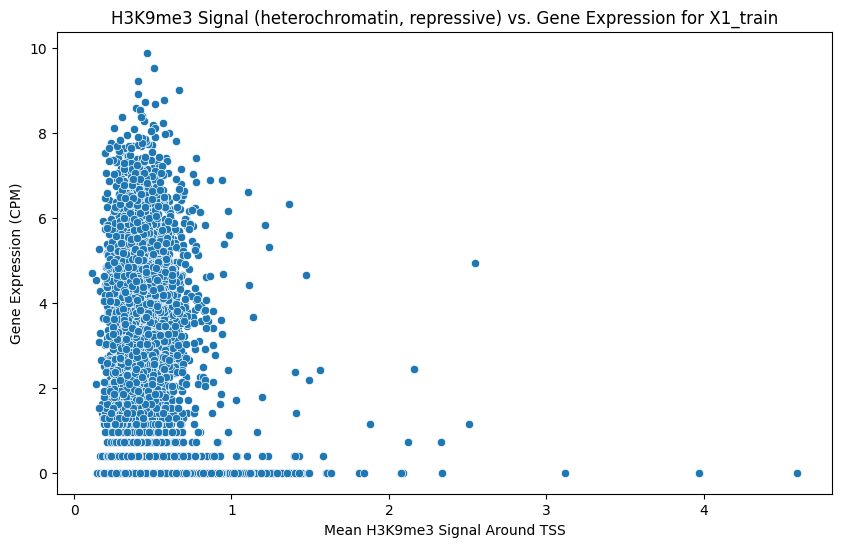

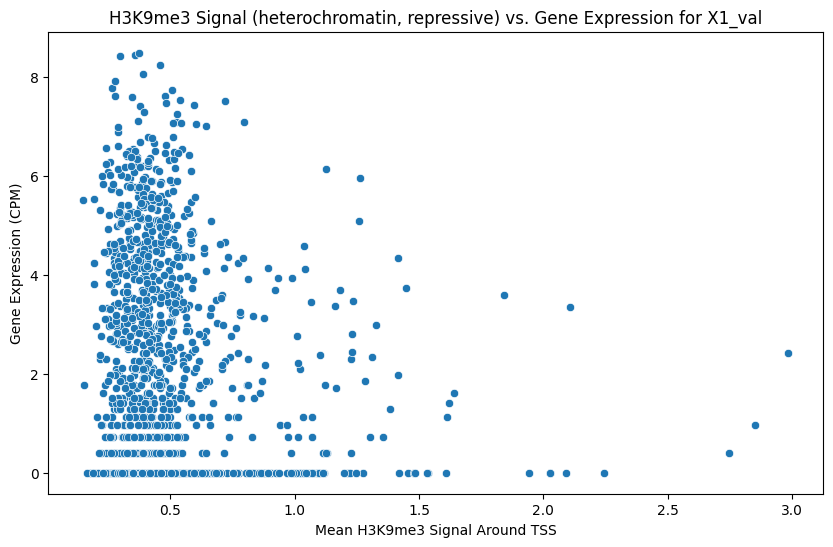

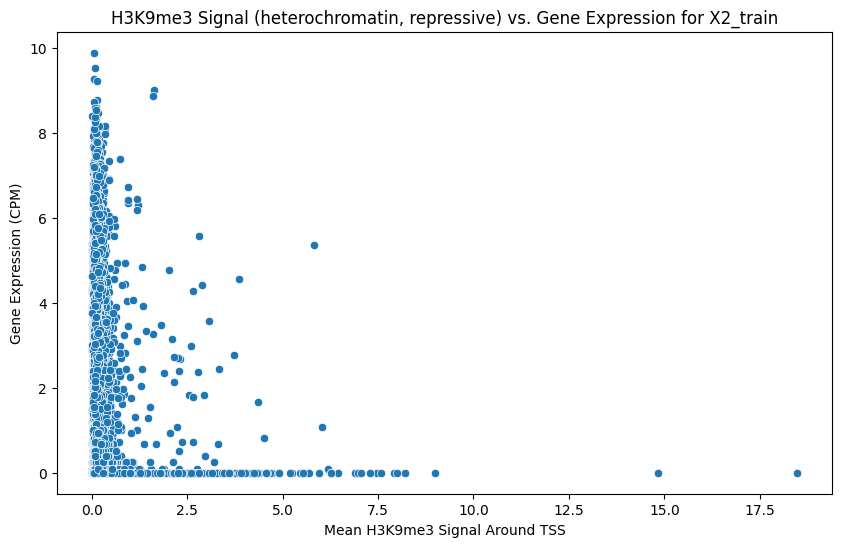

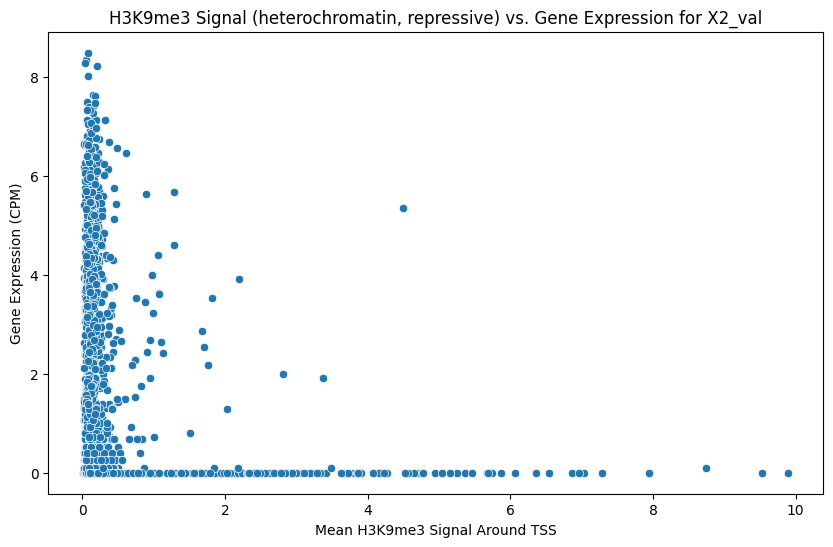

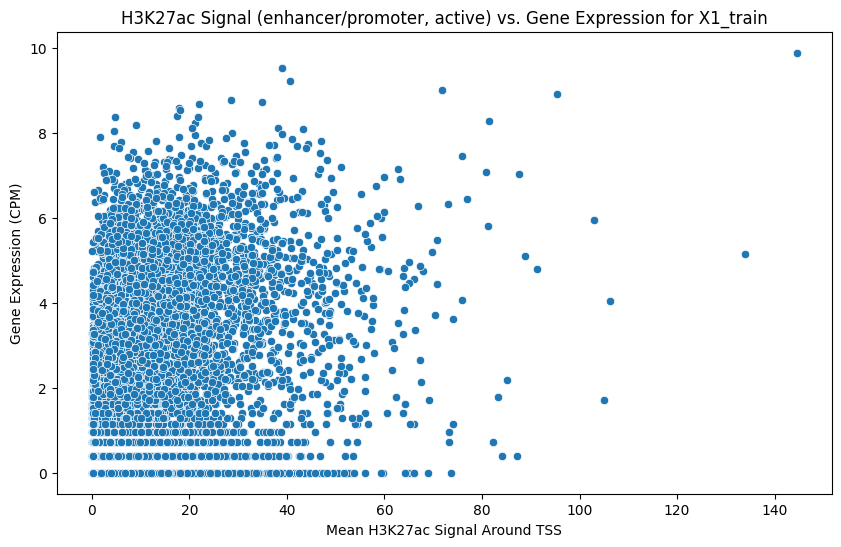

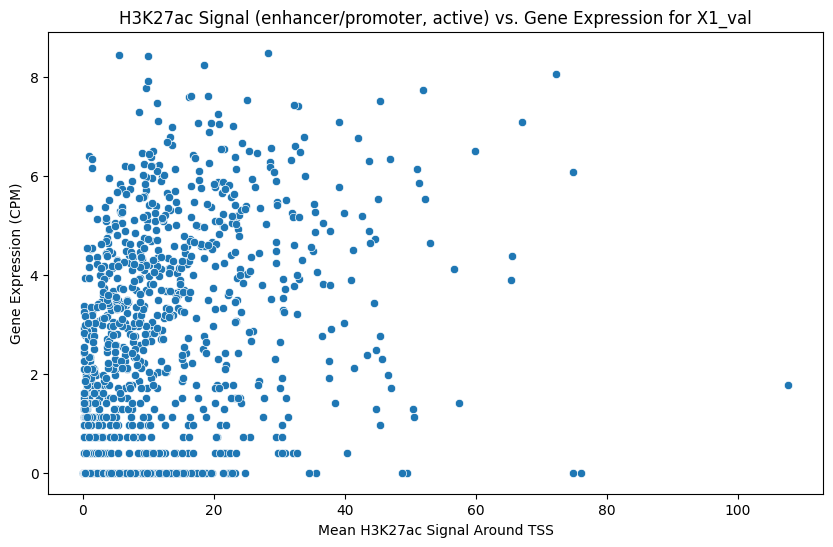

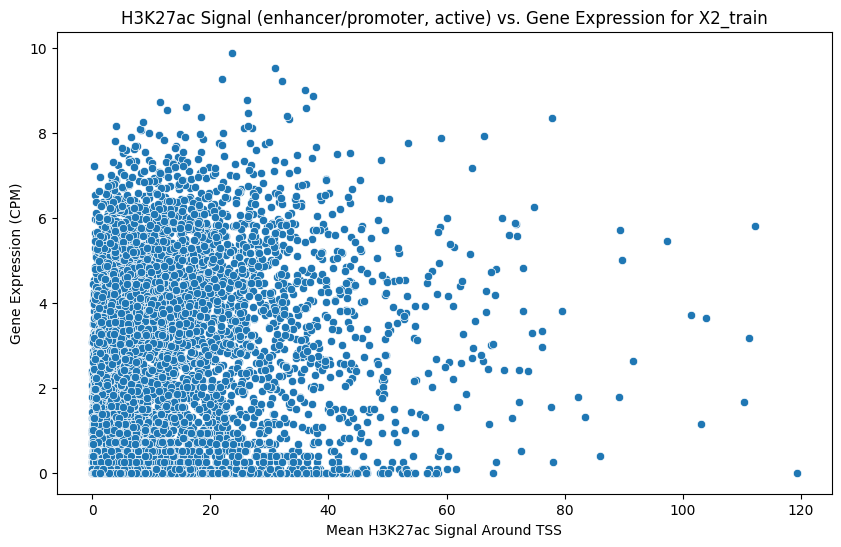

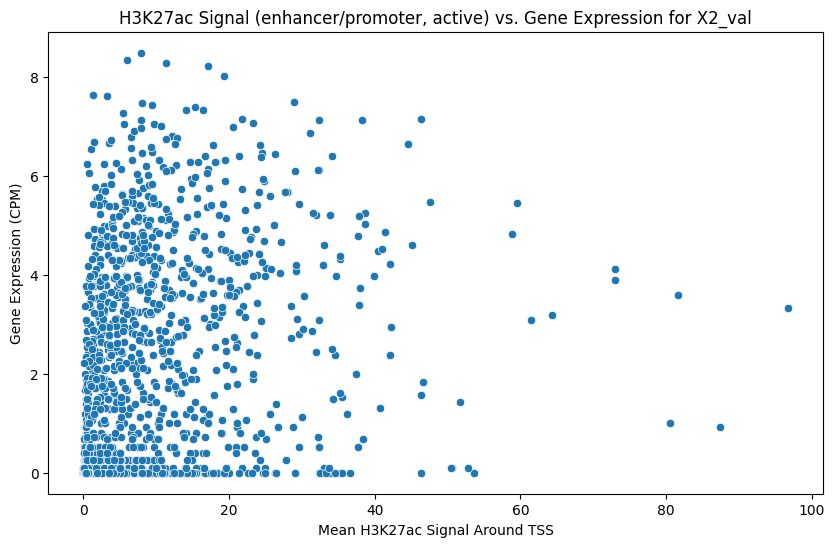

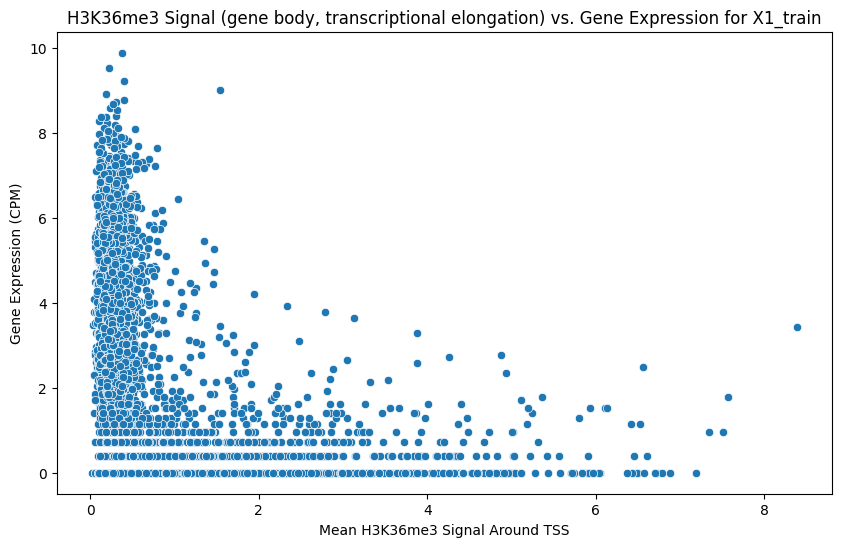

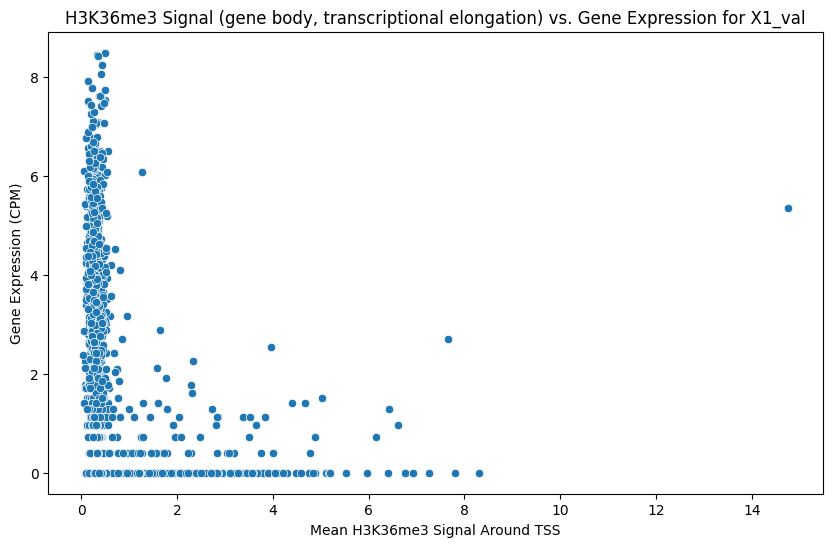

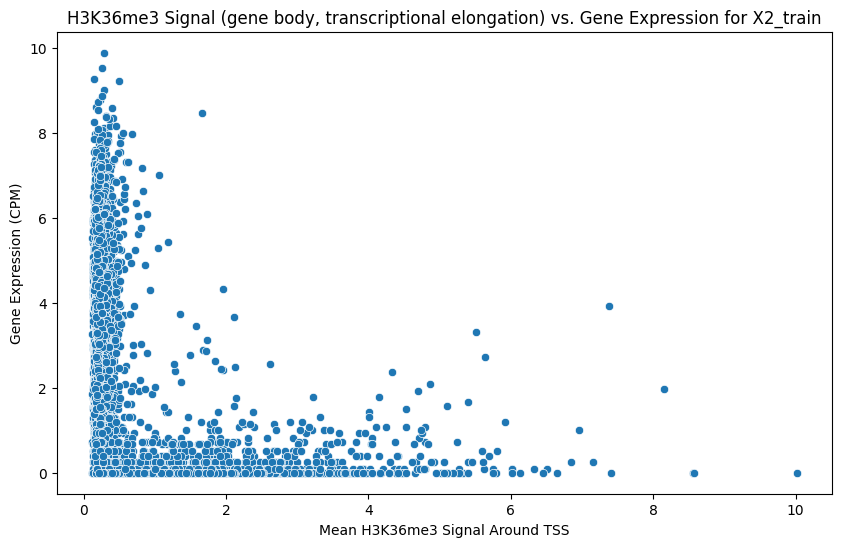

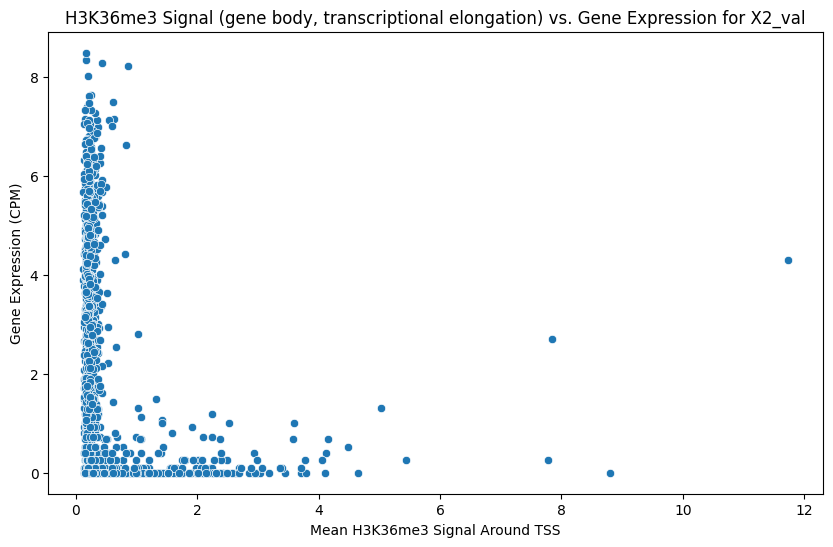

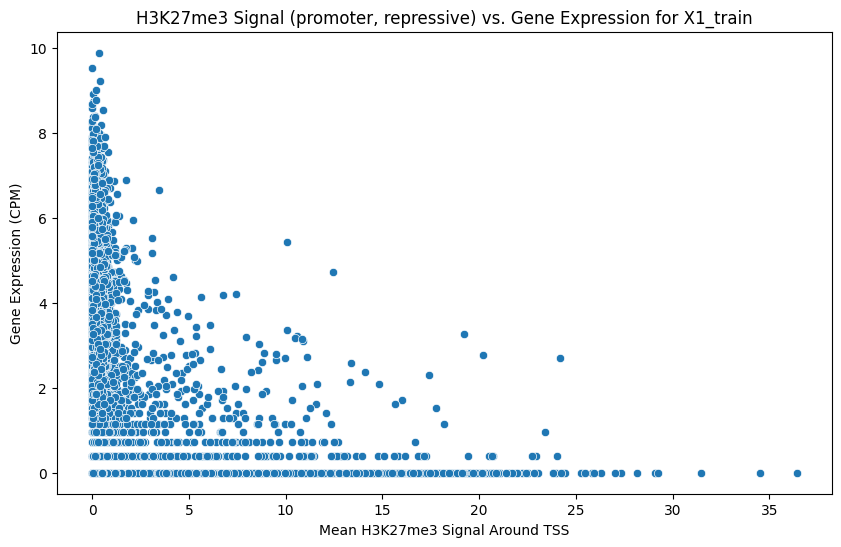

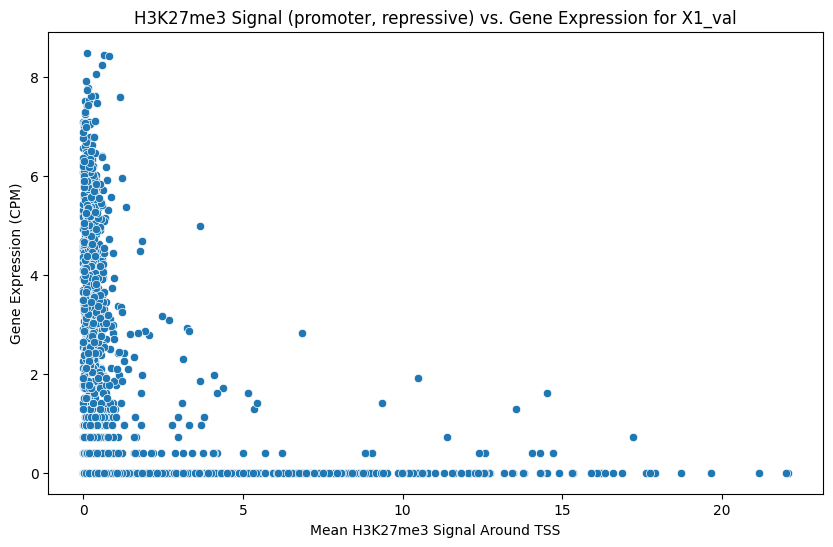

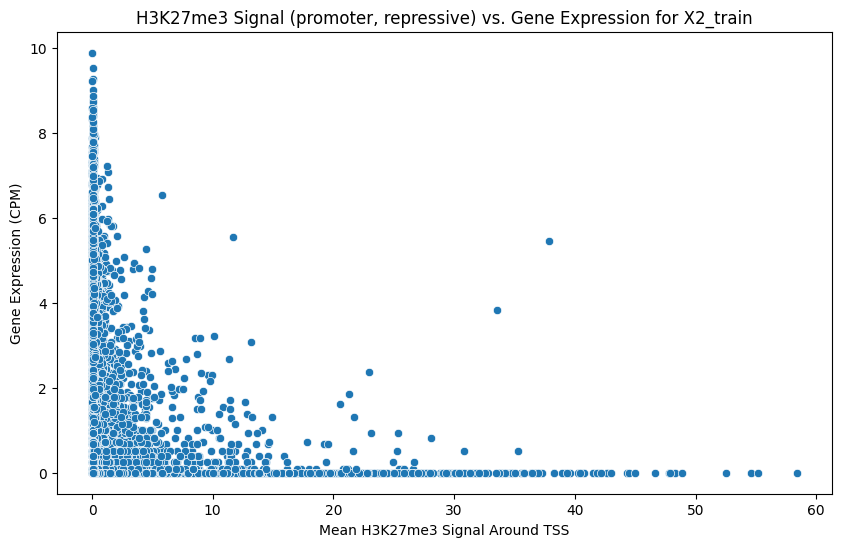

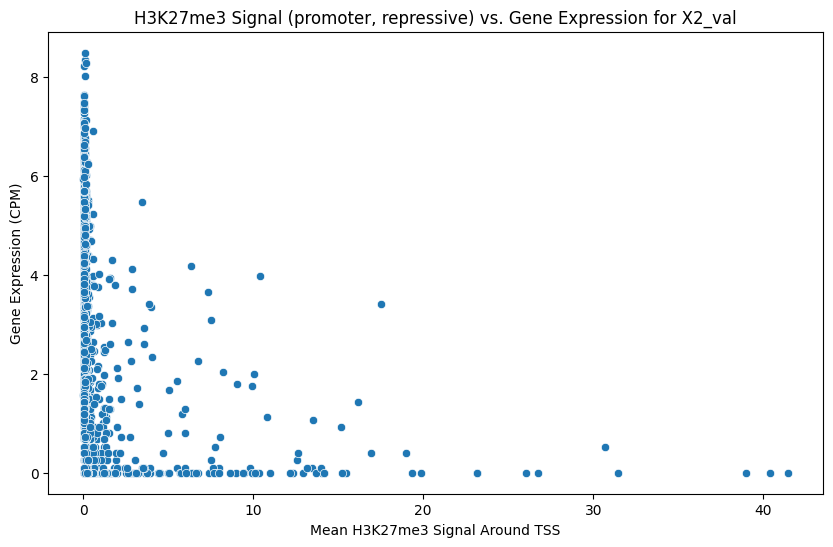

In [177]:
# Plot histone signal vs. gene expression
def plot_histone_signal_vs_gene_expression(df, mark, split):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=mark, y='log_gex', data=df)
    plt.title(f'{mark} Signal ({region_map[mark]}, {effect_map[mark]}) vs. Gene Expression for {split}')
    plt.xlabel(f'Mean {mark} Signal Around TSS')
    plt.ylabel('Gene Expression (CPM)')
    plt.show()

# Iterate over all histone marks and plot signal vs. gene expression
for mark in HISTONE_MARKS:
    # plot_histone_signal_vs_gene_expression(dfs["X1_train"], mark, "X1_train")
    for key in dfs.keys():
        if key == "X3_test_info":
            continue
        plot_histone_signal_vs_gene_expression(dfs[key], mark, key)